In [3]:
import os
import zipfile
import urllib3
import requests
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models  # type: ignore
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [4]:
class DatasetHandler:
    """
    A class to handle dataset downloading, unzipping, loading, and processing.
    """

    def __init__(self, dataset_url, dataset_download_dir, dataset_file, dataset_dir, train_dir, test_dir, val_dir):
        """
        Initialize the DatasetHandler with the specified parameters.

        Args:
            dataset_url (str): URL to download the dataset from.
            dataset_download_dir (str): Directory to download the dataset to.
            dataset_file (str): Name of the dataset file.
            dataset_dir (str): Directory containing the dataset.
            train_dir (str): Directory containing the training data.
            test_dir (str): Directory containing the test data.
            val_dir (str): Directory containing the validation data.
        """
        self.dataset_url = dataset_url
        self.dataset_download_dir = dataset_download_dir
        self.dataset_file = dataset_file
        self.dataset_dir = dataset_dir
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.val_dir = val_dir

    def download_dataset(self):
        """
        Download the dataset from the specified URL.

        Returns:
            bool: True if the dataset was successfully downloaded, False otherwise.
        """
        if not os.path.exists(self.dataset_download_dir):
            os.makedirs(self.dataset_download_dir)
        file_path = os.path.join(self.dataset_download_dir, self.dataset_file)
        if os.path.exists(file_path):
            print(f'dataset file {self.dataset_file} already exists at {file_path}')
            return True
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
        response = requests.get(self.dataset_url, stream=True, verify=False)
        total_size = int(response.headers.get('content-length', 0))
        with open(file_path, 'wb') as file, tqdm(desc=self.dataset_file, total=total_size, unit='iB', unit_scale=True, unit_divisor=1024) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                bar.update(size)
        print(f'dataset downloaded and saved to {file_path}')
        return True

    def unzip_dataset(self):
        """
        Unzip the downloaded dataset file.

        Returns:
            bool: True if the dataset was successfully unzipped, False otherwise.
        """
        file_path = os.path.join(self.dataset_download_dir, self.dataset_file)
        if os.path.exists(self.dataset_dir):
            print(f'dataset is already downloaded and extracted at {self.dataset_dir}')
            return True
        if not os.path.exists(file_path):
            print(f'dataset file {file_path} not found after download')
            return False
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(self.dataset_download_dir)
        print(f'dataset extracted to {self.dataset_dir}')
        return True

    def get_image_dataset_from_directory(self, dir_name):
        """
        Load image dataset from the specified directory.

        Args:
            dir_name (str): Name of the directory containing the dataset.

        Returns:
            tf.data.Dataset: Loaded image dataset.
        """
        dir_path = os.path.join(self.dataset_dir, dir_name)
        return tf.keras.utils.image_dataset_from_directory(
            dir_path,
            labels='inferred',
            color_mode='rgb',
            seed=42,
            batch_size=64,
            image_size=(128, 128)
        )

    def load_split_data(self):
        """
        Load and split the dataset into training, validation, and test datasets.

        Returns:
            tuple: Training, validation, and test datasets.
        """
        train_data = self.get_image_dataset_from_directory(self.train_dir)
        test_data = self.get_image_dataset_from_directory(self.test_dir)
        val_data = self.get_image_dataset_from_directory(self.val_dir)
        return train_data, test_data, val_data


In [5]:
class DeepfakeDetectorModel:
    """
    A class to create and train a deepfake detection model.
    """

    def __init__(self):
        """
        Initialize the DeepfakeDetectorModel by building the model.
        """
        self.model = self._build_model()

    def _build_model(self):
        """
        Build the deepfake detection model architecture.

        Returns:
            tf.keras.Model: Built model.
        """
        model = models.Sequential()
        model.add(layers.Input(shape=(128, 128, 3)))
        model.add(layers.Rescaling(1./127, name='rescaling'))
        model.add(layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
        model.add(layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
        model.add(layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
        model.add(layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
        model.add(layers.Flatten())
        model.add(layers.Dense(512, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        return model

    def compile_model(self, learning_rate):
        """
        Compile the deepfake detection model.

        Args:
            learning_rate (float): Learning rate for the optimizer.
        """
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
        )

    def train_model(self, train_data, val_data, epochs):
        """
        Train the deepfake detection model.

        Args:
            train_data (tf.data.Dataset): Training dataset.
            val_data (tf.data.Dataset): Validation dataset.
            epochs (int): Number of epochs to train the model.

        Returns:
            tf.keras.callbacks.History: History object containing training details.
        """
        early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)
        model_checkpoint_callback = ModelCheckpoint('deepfake_detector_model_best.keras', monitor='val_loss', save_best_only=True, verbose=1)
        return self.model.fit(
            train_data,
            validation_data=val_data,
            epochs=epochs,
            callbacks=[early_stopping_callback, reduce_lr_callback, model_checkpoint_callback]
        )

    def evaluate_model(self, test_data):
        """
        Evaluate the deepfake detection model.

        Args:
            test_data (tf.data.Dataset): Test dataset.

        Returns:
            list: Evaluation metrics.
        """
        return self.model.evaluate(test_data)

    def save_model(self, path):
        """
        Save the deepfake detection model to the specified path.

        Args:
            path (str): Path to save the model.
        """
        self.model.save(path)


In [6]:
class TrainModel:
    """
    A class to manage training of a deepfake detection model.
    """

    def __init__(self, dataset_url, dataset_download_dir, dataset_file, dataset_dir, train_dir, test_dir, val_dir):
        """
        Initialize the TrainModel class with the specified parameters.

        Args:
            dataset_url (str): URL to download the dataset from.
            dataset_download_dir (str): Directory to download the dataset to.
            dataset_file (str): Name of the dataset file.
            dataset_dir (str): Directory containing the dataset.
            train_dir (str): Directory containing the training data.
            test_dir (str): Directory containing the test data.
            val_dir (str): Directory containing the validation data.
        """
        self.dataset_handler = DatasetHandler(dataset_url, dataset_download_dir, dataset_file, dataset_dir, train_dir, test_dir, val_dir)

    def run_training(self, learning_rate=0.0001, epochs=10):
        """
        Run the training process for the deepfake detection model.

        Args:
            learning_rate (float): Learning rate for the optimizer.
            epochs (int): Number of epochs to train the model.

        Returns:
            tuple: History object and evaluation metrics.
        """
        if not self.dataset_handler.download_dataset():
            print('failed to download dataset')
            return
        if not self.dataset_handler.unzip_dataset():
            print('failed to unzip dataset')
            return
        train_data, test_data, val_data = self.dataset_handler.load_split_data()
        model = DeepfakeDetectorModel()
        model.compile_model(learning_rate)
        history = model.train_model(train_data, val_data, epochs)
        evaluation_metrics = model.evaluate_model(test_data)
        model.save_model('deepfake_detector_model.keras')
        return history, evaluation_metrics


if __name__ == '__main__':
    # config
    dataset_url = 'https://www.kaggle.com/api/v1/datasets/download/manjilkarki/deepfake-and-real-images?datasetVersionNumber=1'
    dataset_download_dir = './data'
    dataset_file = 'dataset.zip'
    dataset_dir = './data/Dataset'
    train_dir = 'Train'
    test_dir = 'Test'
    val_dir = 'Validation'

    # instantiate the TrainModel class with the specified configuration
    trainer = TrainModel(
        dataset_url=dataset_url,
        dataset_download_dir=dataset_download_dir,
        dataset_file=dataset_file,
        dataset_dir=dataset_dir,
        train_dir=train_dir,
        test_dir=test_dir,
        val_dir=val_dir
    )

    # train
    history, evaluation_metrics = trainer.run_training(learning_rate=0.0001, epochs=10)

    # metrics
    print('evaluation metrics:', evaluation_metrics)



dataset.zip: 100%|██████████| 1.68G/1.68G [00:24<00:00, 73.3MiB/s]


dataset downloaded and saved to ./data/dataset.zip
dataset extracted to ./data/Dataset
Found 140002 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Epoch 1/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7307 - loss: 0.5370 - precision: 0.7189 - recall: 0.7576
Epoch 1: val_loss improved from inf to 0.21988, saving model to deepfake_detector_model_best.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 144s 60ms/step - accuracy: 0.7308 - loss: 0.5369 - precision: 0.7190 - recall: 0.7576 - val_accuracy: 0.9079 - val_loss: 0.2199 - val_precision: 0.9095 - val_recall: 0.9066 - learning_rate: 1.0000e-04
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9351 - loss: 0.1605 - precision: 0.9319 - recall: 0.9387
Epoch 2: val_loss did not improve from 0.21988
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 122s 56ms/step - accuracy: 0.9351 - loss: 0.1605 - precision: 0.9319 - recall: 0.9387 - val_accuracy: 0.8967 - val_loss: 0.22

In [7]:
import matplotlib.pyplot as plt

evaluation metrics: [0.42484620213508606, 0.884181559085846, 0.9131820201873779, 0.8472196459770203]


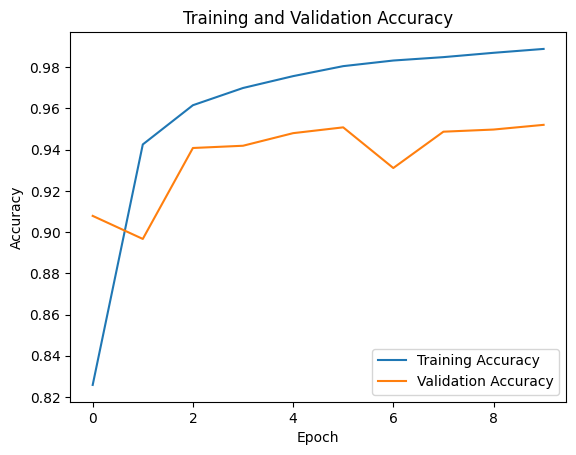

In [8]:
print('evaluation metrics:', evaluation_metrics)

    # Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

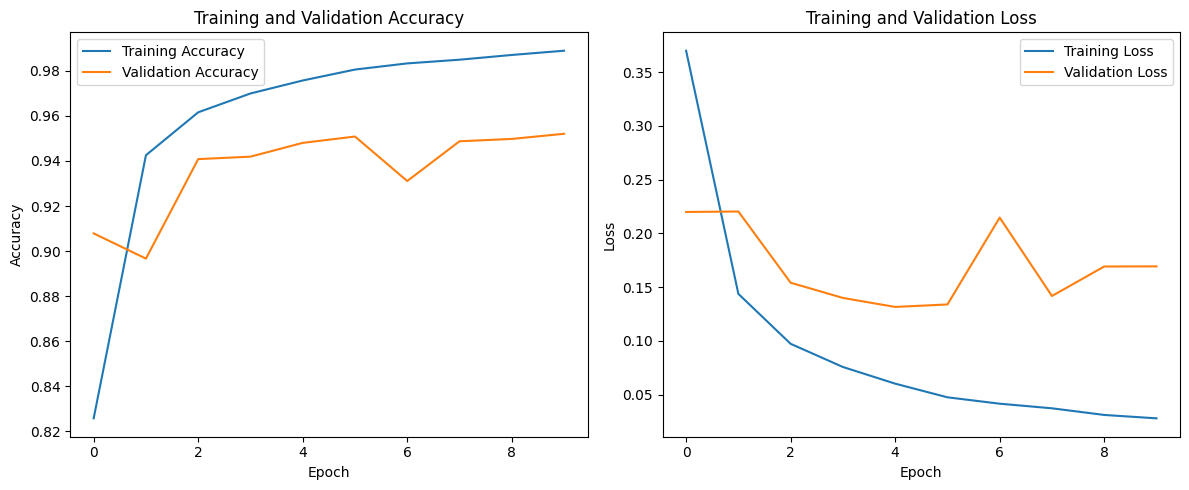

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].legend()

    # Loss plot
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].legend()

plt.tight_layout()
plt.show()